In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
data = pd.read_csv('./input/data-changepoint.txt')
data.head()

,X,Y
0,1,-0.25
1,2,1.92
2,3,-0.57
3,4,-1.41
4,5,-0.90


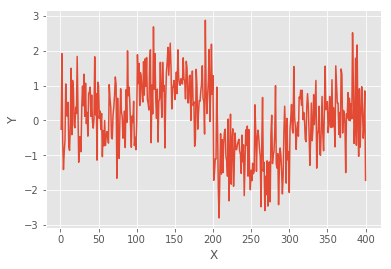

In [3]:
sns.lineplot(data=data, x='X', y='Y')

In [4]:
stan_model = """

data {
  int T;
  vector[T] Y;
}

parameters {
  real mu0;
  vector<lower=-pi()/2, upper=pi()/2>[T-1] mu_raw;
  real<lower=0> s_mu;
  real<lower=0> s_Y;
}

transformed parameters {
  vector[T] mu;
  mu[1] = mu0;
  for (t in 2:T){
    mu[t] = mu[t-1] + s_mu * tan(mu_raw[t-1]);
  }
}

model {
  Y ~ normal(mu, s_Y);
}
"""

In [5]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6832e7fa4e5f587c8b446fa4e532be46 NOW.


In [6]:
stan_data = {}
stan_data['T'] = data.shape[0]
stan_data['Y'] = data['Y']

In [7]:
fit = sm.sampling(stan_data)

In [8]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_6832e7fa4e5f587c8b446fa4e532be46.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%     25%     50%    75%  97.5%  n_eff   Rhat
mu0           0.11  5.4e-3    0.2  -0.33 -4.4e-4    0.11   0.22    0.5   1438    1.0
mu_raw[1]     0.02    0.01   0.88  -1.47   -0.73    0.01   0.76   1.48   4916    1.0
mu_raw[2]    -0.06    0.01    0.9  -1.52   -0.86   -0.07   0.71   1.46   3975    1.0
mu_raw[3]    -0.03    0.01   0.88  -1.49   -0.79   -0.05   0.72   1.45   4964    1.0
mu_raw[4]     0.02    0.01   0.88  -1.46   -0.74    0.03   0.77   1.48   4849    1.0
mu_raw[5]     0.07    0.01   0.91  -1.45   -0.72    0.09   0.87   1.52   4428    1.0
mu_raw[6]     0.09    0.02   0.92  -1.45   -0.72    0.11   0.92   1.54   3544    1.0
mu_raw[7]     0.05    0.01    0.9  -1.45   -0.74    0.07   0.81   1.49   5778    1.0
mu_raw

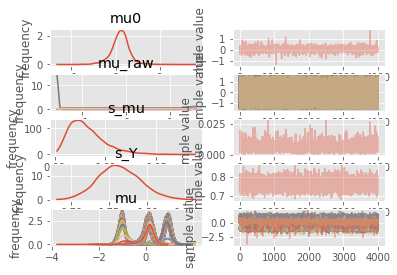

In [9]:
fig = fit.plot()

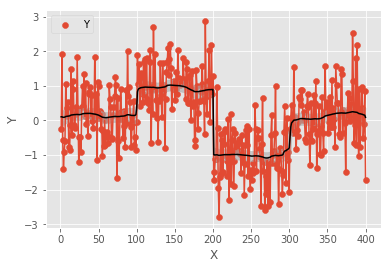

In [10]:
sample_mu = fit.extract('mu')['mu']
lower80, upper80 = mstats.mquantiles(sample_mu, [0.1, 0.9], axis=0)
plt.scatter(data['X'], data['Y'])
plt.fill_between(data['X'].unique(), lower80, upper80, alpha=0.6, color='darkgray')
sns.lineplot(data=data, x='X', y='Y')

x = data['X'].unique()
y = np.mean(sample_mu, axis=0)
plt.plot(x, y, color='black')